# JOREK-CARIDDI Bohdan Glisevic

In thi Jupyter notebook, I summarised my work over the past 2 weeks on JOREK-CARIDDI coupling. I decided to the whole process first in Python as I am more familiar with the language but I am slowly translating the algorithm into Fortran. To run this document properly, you need two data documents:

- JOREK boundary data points (`boundary.txt`) that are in polar coordinate system from Nina
- CARIDDI wall data points (`XYZ.txt`) that are in 3D cartesian coordinates from Nicola

All of the necessary documents for smooth run of the notebook should be in the folder.

As mentioned above, data points from CARIDDI are in cartesian coordinates, but because JOREK boundary is symmetrical in toroidal direction, I decided to convert data points from CARIDDI into cylindrical (cylindrical-polar) coordiantes and then works with each todoidal angle of CARIDDI wall separately. 

\begin{align*}
\rho &= \sqrt{x^2 + y^2} \\
\phi &= \tan{\frac{y}{x}} \\
z &= z
\end{align*}

## Libraries and Coordinates Converters

In this section, I present libraries that I used thorughout the whole notebook. I tried to use as little dedicated functions from these libraries as possible as it would just make it more difficult to translate into Fortran later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

def cartesian2cyl(x,y,z):
    '''
    This function converts cartesian cooridantes to cylindrical coordinates.
    Input:
        x   - x cooridnate    [float or an array of floats]
        y   - y cooridnate    [float or an array of floats]
        z   - z cooridnate    [float or an array of floats]
    Output:
        rho - radial distance [float or an array of floats]
        phi - polar angle     [float or an array of floats]
        z   - height          [float or an array of floats]
    Assumptions:
        - NumPy library has been already called
    '''
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/x)
    z = z
    return rho, phi, z

def cyl2cartesian(rho, phi, z):
    '''
    This function converts cylindrical cooridantes to cartesian coordinates.
    Input:
        rho - radial distance [float or an array of floats]
        phi - polar angle     [float or an array of floats]
        z   - height          [float or an array of floats]
    Output:
        x   - x cooridnate    [float or an array of floats]
        y   - y cooridnate    [float or an array of floats]
        z   - z cooridnate    [float or an array of floats]
    Assumptions:
        - NumPy library has been already called
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    z = z
    return x, y, z

## JOREK Boundary

In the cell bellow, I plotted the JOREK boundary which represents outer layer of the plasma from simulation. Throughout the notebook, I use blue colour to indicate JOREK boundary

In [2]:
bnd = np.loadtxt('boundary.txt', skiprows = 1, max_rows = 100)

rho_bnd = bnd[:,3]          # radial distance [m]
z_bnd   = bnd[:,4]          # height [m]

<IPython.core.display.Javascript object>


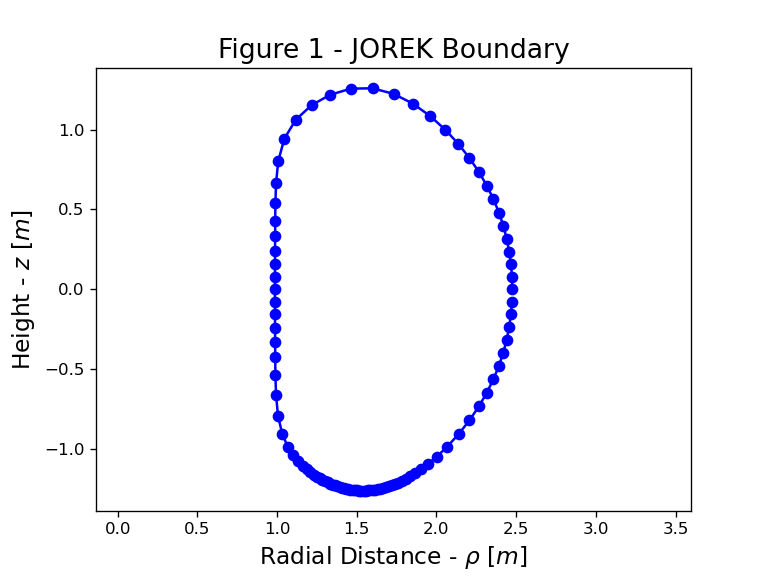

In [3]:
## Figure 1 ##
plt.figure()
plt.plot(rho_bnd, z_bnd, '-o', color = 'blue')

plt.xlabel(r'Radial Distance - $\rho$ $[m]$', fontsize = 14)
plt.ylabel(r'Height - $z$ $[m]$', fontsize = 14)
plt.title('Figure 1 - JOREK Boundary', fontsize = 16)
plt.axis('equal')

plt.show()

## CARIDDI Wall

Document from CARIDDI contains more geometrical information of electrodes in the wall. From the data file, we obtain nodes of hexahedrals. The face of hexahedral (quadrilateral) closest to the plasma boundary is an electrode. The whole CARIDDI wall has shape of torus. In the cell below, I plotted CARIDDI wall. Throughout the whole notebook, CARIDDI wall is indicated by red colour (I will emphasise if this changes in any cell)

In [4]:
car = np.loadtxt('text_files/XYZ.dat', unpack = True)                # load CARIDDI wall nodes
x_car,y_car,z_car = car[0,:], car[1,:], car[2,:]                     # cartesian components of nodes

<IPython.core.display.Javascript object>


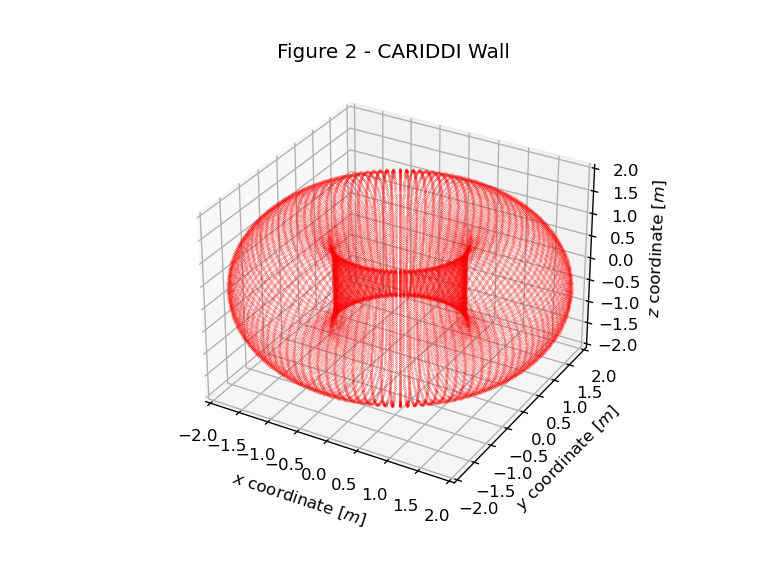

In [5]:
## Figure 2 ##
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.plot(x_car, y_car, z_car,'o', markersize = 0.1, linewidth = 0.1, color = 'red')

ax.set_xlabel(r'$x$ coordinate $[m]$')
ax.set_ylabel(r'$y$ coordinate $[m]$')
ax.set_zlabel(r'$z$ coordinate $[m]$')
limit = 2
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
plt.title('Figure 2 - CARIDDI Wall')
plt.show()

As mentioned in the introduction, I decided to work with toroidal section separately. From the previous analysis, I know that each toroidal section contains 322 data points. I call these sections 'layers' and each data point cantains information of its layer (toroidal section), its order in this one section and 3 cartesian coordinates. In the Fiure 3, I show only 3 layers for 3 different toroidal angles and in the Figure 4, I highlighted one layer from the whole CARIDDI wall.

In [6]:
polar_angles = 120          # number of distinct polar angles in CARIDDI (toroidal angles)
points       = 322          # number of points per polar angle
ndim         = 3            # number of cooridnates

layers = np.zeros((points,polar_angles,ndim))         # individiual polar layers of CARIDDI

for i in range(polar_angles):
    layers[:,i,0] = x_car[int(i*points):int((i+1)*points)]
    layers[:,i,1] = y_car[int(i*points):int((i+1)*points)]
    layers[:,i,2] = z_car[int(i*points):int((i+1)*points)]

<IPython.core.display.Javascript object>


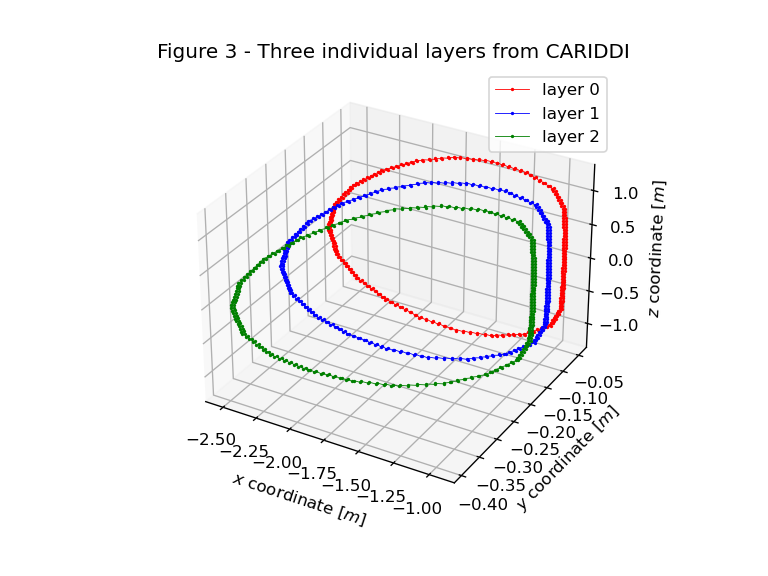

<IPython.core.display.Javascript object>


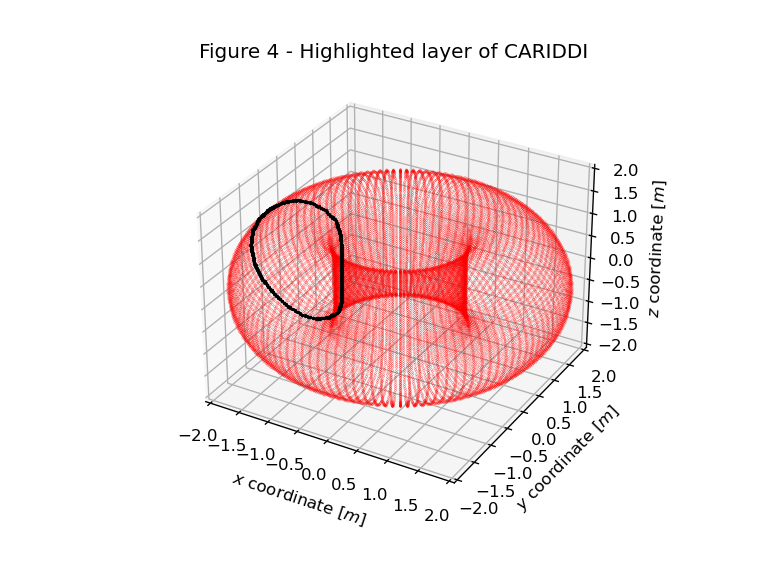

In [7]:
## Figure 3 ##

fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')

colors = ['red','blue','green']

for layer in range(3):
    plt.plot(layers[:,layer,0],
             layers[:,layer,1],
             layers[:,layer,2], '-o', markersize = 1, linewidth = 0.5, color = colors[layer], label = f'layer {layer}')


plt.legend(loc = 'best')
ax1.set_xlabel(r'$x$ coordinate $[m]$')
ax1.set_ylabel(r'$y$ coordinate $[m]$')
ax1.set_zlabel(r'$z$ coordinate $[m]$')
plt.title('Figure 3 - Three individual layers from CARIDDI')
plt.show()

## Figure 4 ##
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
plt.plot(x_car, y_car, z_car,'o', markersize = 0.1, linewidth = 0.1, color = 'red')
plt.plot(layers[:,0,0],
         layers[:,0,1],
         layers[:,0,2], '-o', markersize = 1, linewidth = 0.5, color = 'black', label = f'layer {0}')

ax2.set_xlabel(r'$x$ coordinate $[m]$')
ax2.set_ylabel(r'$y$ coordinate $[m]$')
ax2.set_zlabel(r'$z$ coordinate $[m]$')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.set_zlim(-2,2)
plt.title('Figure 4 - Highlighted layer of CARIDDI')
plt.show()

Futher, in one layer of CARIDDI, we can see by using the plots below, that it contains outer and inner region of the wall where the inner region are electrodes (to show electrodes which are one face of the hexahedral, we must use at least two layers) 

<IPython.core.display.Javascript object>


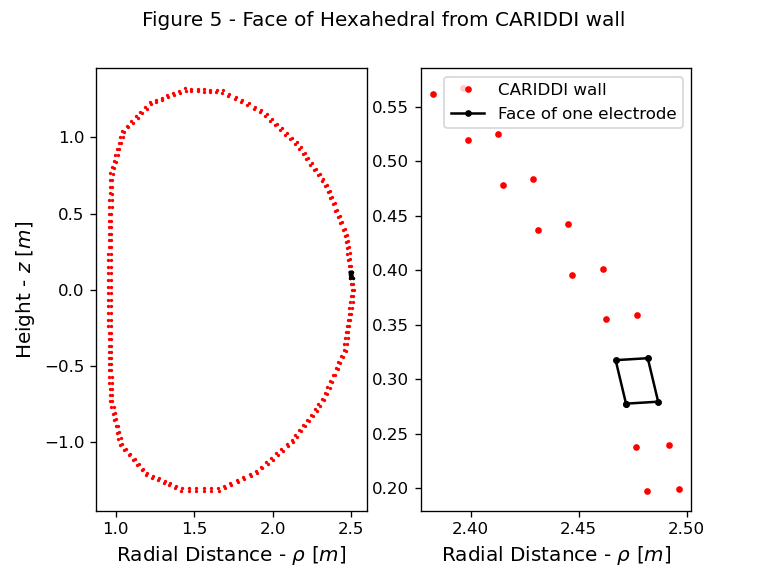

<IPython.core.display.Javascript object>


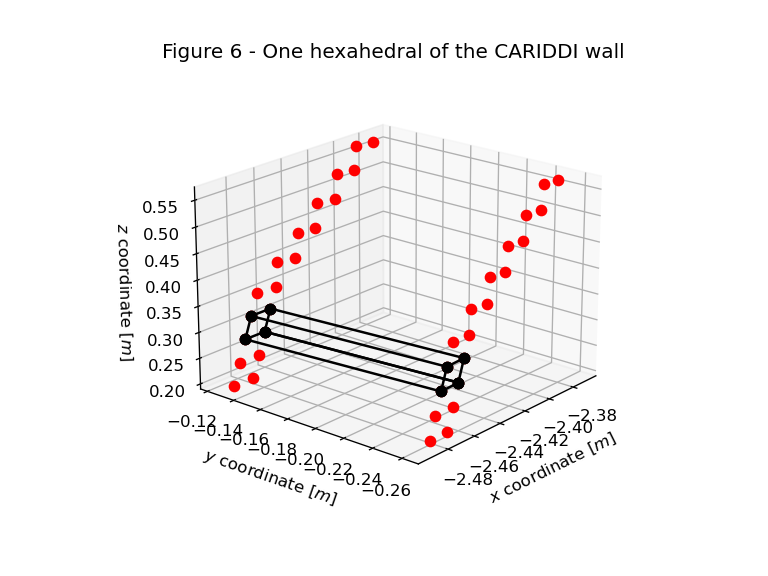

In [8]:
## Figure 5 ##
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Figure 5 - Face of Hexahedral from CARIDDI wall')
x, y, z = layers[:,0,0], layers[:,0,1], layers[:,0,2]        # Isolate one layer
rho, phi, z = cartesian2cyl(x, y, z)

ax1.plot(rho, z, 'o', markersize = 1, color = 'red', label = 'CARIDDI wall')
start_index = 4
ax1.plot([rho[start_index], rho[start_index+1], rho[start_index+3], rho[start_index+2], rho[start_index]], 
         [z[start_index],   z[start_index+1],   z[start_index+3],   z[start_index+2],  z[start_index]], 
         '-o', markersize = 1, color = 'black', label = 'Face of one electrode')

ax1.set_xlabel(r'Radial Distance - $\rho$ $[m]$', fontsize = 12)
ax1.set_ylabel(r'Height - $z$ $[m]$', fontsize = 12)

x, y, z = layers[10:30,0,0], layers[10:30,0,1], layers[10:30,0,2]        # Isolate one layer
rho, phi, z = cartesian2cyl(x, y, z)

ax2.plot(rho, z, 'o', markersize = 3, color = 'red', label = 'CARIDDI wall')
ax2.plot([rho[start_index], rho[start_index+1], rho[start_index+3], rho[start_index+2], rho[start_index]], 
         [z[start_index],   z[start_index+1],   z[start_index+3],   z[start_index+2],  z[start_index]], 
         '-o', markersize = 3, color = 'black', label = 'Face of one electrode')


ax2.set_xlabel(r'Radial Distance - $\rho$ $[m]$', fontsize = 12)
plt.legend(loc = 'best')

plt.show()

## Figure 6 ##

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x1, y1, z1 = layers[10:30,0,0], layers[10:30,0,1], layers[10:30,0,2]        # Isolate first layer
x2, y2, z2 = layers[10:30,1,0], layers[10:30,1,1], layers[10:30,1,2]        # Isolate second layer

plt.plot(x1, y1, z1, 'o', color = 'red')
plt.plot(x2, y2, z2, 'o', color = 'red')
start_index = 4
plt.plot([x1[start_index], x1[start_index+1], x1[start_index+3], x1[start_index+2], x1[start_index], x2[start_index], x2[start_index+1], x2[start_index+3], x2[start_index+2], x2[start_index]], 
         [y1[start_index], y1[start_index+1], y1[start_index+3], y1[start_index+2], y1[start_index], y2[start_index], y2[start_index+1], y2[start_index+3], y2[start_index+2], y2[start_index]], 
         [z1[start_index], z1[start_index+1], z1[start_index+3], z1[start_index+2], z1[start_index], z2[start_index], z2[start_index+1], z2[start_index+3], z2[start_index+2], z2[start_index]], 
         '-o', color = 'black')

for i in range(4):
    plt.plot([x1[start_index+i],x2[start_index+i]], [y1[start_index+i],y2[start_index+i]], [z1[start_index+i],z2[start_index+i]], '-o', color = 'black')

plt.title('Figure 6 - One hexahedral of the CARIDDI wall')
ax.view_init(20, 220)
ax.set_xlabel(r'$x$ coordinate $[m]$')
ax.set_ylabel(r'$y$ coordinate $[m]$')
ax.set_zlabel(r'$z$ coordinate $[m]$')
plt.show()

## JOREK-CARIDDI 

(This part of the notebook can run independently from other cells above - that's why I repeated some of the functions)

Finally, in this section I created points on CARIDDI wall that we are interested in. To do that I decided to treat each toroidal layer separately. I first convert cartesian coordinates of CARIDDI wall into cylindrical coordinates and omit the angle $\phi$ as this is constant for one toroidal section. Then I calculate normal points on this one layer using the nodes of JOREK boundary. Process of finding these normal points can be found in the picture below.

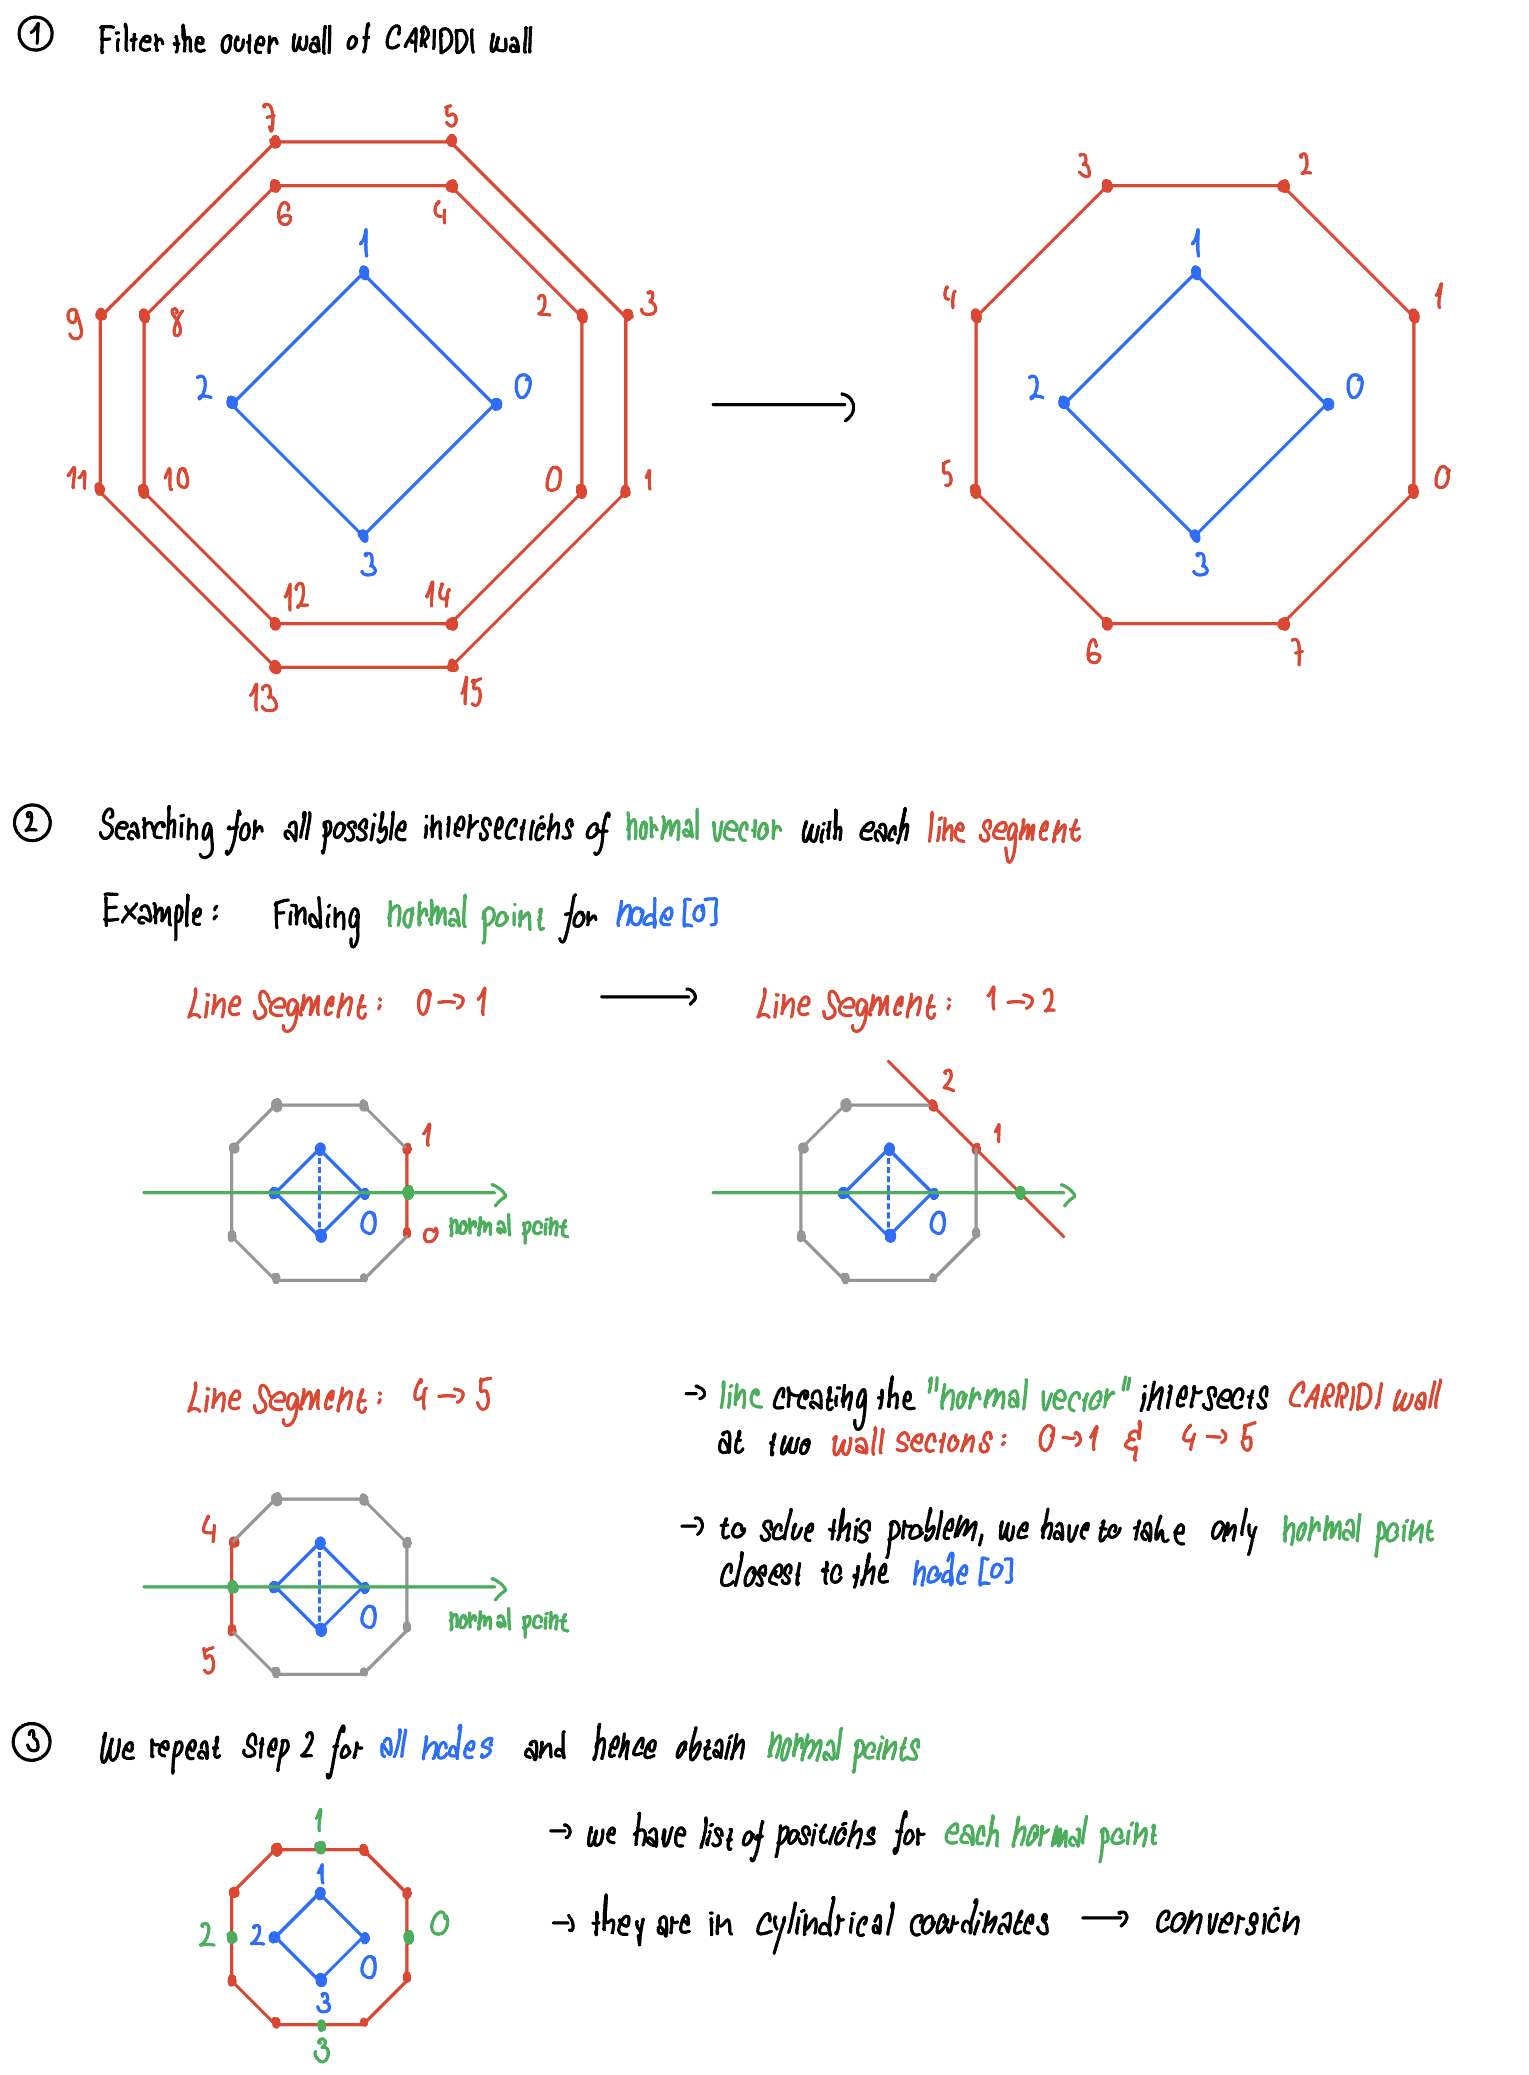

In [9]:
from IPython.display import Image
Image('process.png', width = 800)

In [10]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib notebook

def cartesian2cyl(x,y,z):
    '''
    This function converts cartesian cooridantes to cylindrical coordinates.
    Input:
        x   - x cooridnate    [float or an array of floats]
        y   - y cooridnate    [float or an array of floats]
        z   - z cooridnate    [float or an array of floats]
    Output:
        rho - radial distance [float or an array of floats]
        phi - polar angle     [float or an array of floats]
        z   - height          [float or an array of floats]
    Assumptions:
        - NumPy library has been already called
    '''
    rho = np.sqrt(x**2 + y**2)
    n = len(z)
    phi = np.zeros(n)
    for i in range(n):
        if y[i] >= 0 and x[i] < 0:
            phi[i] = np.pi + np.arctan(y[i]/x[i])
        elif y[i] < 0 and x[i] < 0:
            phi[i] = - (np.pi - np.arctan(y[i]/x[i]))
        else:
            phi[i] = np.arctan(y[i]/x[i])
    z = z
    return rho, phi, z

def cyl2cartesian(rho, phi, z):
    '''
    This function converts cylindrical cooridantes to cartesian coordinates.
    Input:
        rho - radial distance [float or an array of floats]
        phi - polar angle     [float or an array of floats]
        z   - height          [float or an array of floats]
    Output:
        x   - x cooridnate    [float or an array of floats]
        y   - y cooridnate    [float or an array of floats]
        z   - z cooridnate    [float or an array of floats]
    Assumptions:
        - NumPy library has been already called
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    z = z
    return x, y, z

def normal_vector_point(point, point_after, point_before, point_A, point_B):
    '''
    Calcualtes position of a point on the CARIDDI wall normal to the point on the JOREK boundary
    Input:
        point        - point on the JOREK boundary whose normal point we want to find [array of floats]
        point_after  - point on the JOREK boundary above the 'point' of interest [array of floats]
        point_before - point on the JOREK boundary below the 'point' of interest [array of floats]
        point_A      - point 1 of the line segment on CARIDDI that we are testing for normal intersection [array of floats]
        point_B      - point 2 of the line segment on CARIDDI that we are testing for normal intersection [array of floats]
    Output:
        x, y - array of positions x and y for the point on the CARIDDI wall normal to the point on the JOREK boundary
    Assumptions:
        - NumPy library has been already called
        
    '''
    term1 = point[0] * (point_after[0] - point_before[0]) * (point_B[0] - point_A[0])
    term2 = point_A[0] * (point_B[1] - point_A[1]) * (point_after[1] - point_before[1])
    term3 = (point_after[1] - point_before[1]) * (point_B[0] - point_A[0]) * (point[1] - point_A[1])
    term4 = (point_B[1] - point_A[1]) * (point_after[1] - point_before[1]) + (point_B[0] - point_A[0]) * (point_after[0] - point_before[0])
    
    x = (term1 + term2 + term3) / term4
    y = (point[0] - x) * (point_after[0] - point_before[0]) / (point_after[1] - point_before[1]) + point[1]
    return np.array([x,y])

def magnitude(vec1, vec2):
    '''
    Calculates distance between two vectors.
    Input:
        vec1 - first vector  [float or an array of floats]
        vec1 - second vector [float or an array of floats]
    Output:
        magnitude - distance [float]
    Assumptions:
        - NumPy library has been already called
    '''
    magnitude = np.sqrt((vec1[0]-vec2[0])**2 + (vec1[1]-vec2[1])**2)
    return magnitude

In [11]:
car = np.loadtxt('text_files/XYZ.dat', unpack = True)                   # load CARIDDI wall nodes
bnd = np.loadtxt('boundary.txt', skiprows = 1, max_rows = 100)          # load JOREK boundary points

x_car, y_car, z_car = car[0,:], car[1,:], car[2,:]                        # cartesian components of nodes on CARIDDI wall

rho_bnd = bnd[:,3]          # radial distance [m]
z_bnd   = bnd[:,4]          # height [m]

num_tor_angles = 120                      # number of toroidal sections
points_car   = 322                        # number of points on CARIDDI wall per toroidal angle
points_bnd   = 100                        # number of points on JOREK boundary per toroidal angle

normal_points = np.zeros((3, int(points_bnd * num_tor_angles)))         # points on the CARIDDI wall noraml to the 
                                                                        # JOREK boundary nodes

In [12]:
for k in range(num_tor_angles):
    Xcar = car[0,k*points_car:(k+1)*points_car]  # x-coords of nodes in 1 toroidal layer on CARIDDI wall
    Ycar = car[1,k*points_car:(k+1)*points_car]  # y-coords of nodes in 1 toroidal layer on CARIDDI wall
    Zcar = car[2,k*points_car:(k+1)*points_car]  # z-coords of nodes in 1 toroidal layer on CARIDDI wall        

    RHOcar, PHIcar, Zcar = cartesian2cyl(Xcar,Ycar,Zcar)        # nodes on the CARIDDI wall in cylindrical coordiantes
    RHOcar, PHIcar, Zcar = RHOcar[0::2], PHIcar[0::2], Zcar[0::2]                       # exclusion of the outer layer of CARIDDI wall
    
    phi_bnd = PHIcar[0] * np.ones(points_bnd)         # toroidal angles of normal points on CARIDDI wall
    
    rho_list = []          # empty list for radial distance of normal points in one torodial layer
    z_list   = []          # empty list for height of normal points in one torodial layer
    
    for i in range(-2, points_bnd-2):
        point        = np.array([rho_bnd[i+1], z_bnd[i+1]])            # point of interest from JOREK boundary
        point_after  = np.array([rho_bnd[i+2], z_bnd[i+2]])            # point above the point of interest
        point_before = np.array([rho_bnd[i],   z_bnd[i]])              # point below the point of interest
        for j in range(-1,int(points_car/2)-1):
            point_A = np.array([RHOcar[j],   Zcar[j]])               # point 1 from the section of CARIDDI wall
            point_B = np.array([RHOcar[j+1], Zcar[j+1]])             # point 2 from the section of CARIDDI wall
            rho, z  = normal_vector_point(point, point_after, point_before, point_A, point_B)
            
            ## Condition for noraml point being on the CARIDDI wall ##
            if rho > point_B[0] and rho < point_A[0]:                          
                if point_B[1] > point_A[1]:
                    if z < point_B[1] and z > point_A[1]:
                        rho_list.append(rho)
                        z_list.append(z)
                else:
                    if z >  point_B[1] and z < point_A[1]:
                        rho_list.append(rho)
                        z_list.append(z)
            elif rho < point_B[0] and rho > point_A[0]:                  
                if point_B[1] >  point_A[1]:
                    if z < point_B[1] and z > point_A[1]:
                        rho_list.append(rho)
                        z_list.append(z)
                else:
                    if z >  point_B[1] and z < point_A[1]:
                        rho_list.append(rho)
                        z_list.append(z)
    
    intercepts = np.zeros((2,2,points_bnd))             # zero array for all the normal points found
    intercepts[0,:,:] = rho_list[0::2], z_list[0::2]
    intercepts[1,:,:] = rho_list[1::2], z_list[1::2]
    
    normal_points_layer = np.zeros((2,points_bnd))      # closest normal points to the points of interest
    
    ## To distinguish close and far normal points ##
    for i in range(0,points_bnd):
        small_list = []
        for j in range(2):
            mag = magnitude(intercepts[j,:,i], np.array([rho_bnd[i-1], z_bnd[i-1]]))
            small_list.append(mag)
        min_arg = np.argmin(small_list)
        normal_points_layer[:,i] = intercepts[min_arg,:,i]
        
    normal_points[:,k*points_bnd:(k+1)*points_bnd] = cyl2cartesian(normal_points_layer[0,:], phi_bnd, normal_points_layer[1,:])

<IPython.core.display.Javascript object>


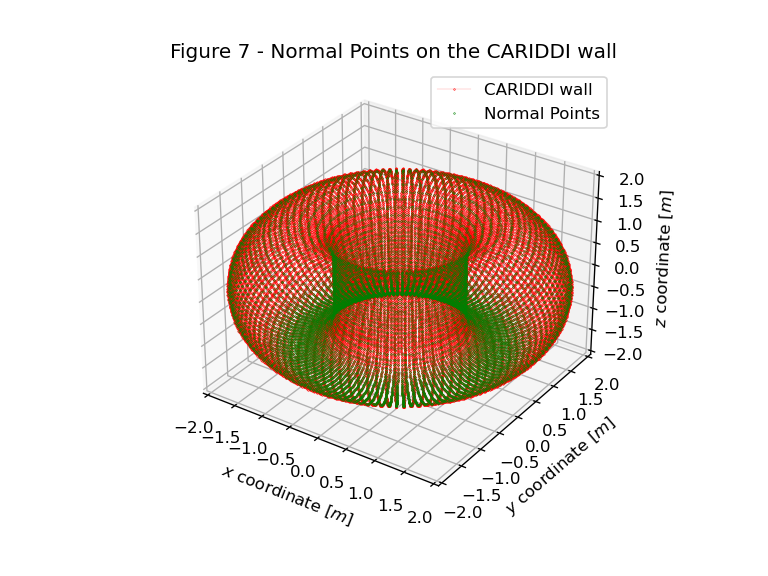

In [18]:
## Figure 7 ##

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


plt.plot(x_car, y_car, z_car,'-o', markersize = 0.3, linewidth = 0.1, color = 'red', label = 'CARIDDI wall')
plt.plot(normal_points[0,:], normal_points[1,:], normal_points[2,:],
         'o', markersize = 0.3, linewidth = 0.1, color = 'green', label = 'Normal Points')


ax.set_xlabel(r'$x$ coordinate $[m]$')
ax.set_ylabel(r'$y$ coordinate $[m]$')
ax.set_zlabel(r'$z$ coordinate $[m]$')
plt.legend(loc = 'best')
limit = 2
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
plt.title('Figure 7 - Normal Points on the CARIDDI wall')
plt.show()

In [32]:
np.savetxt('normal_points.txt', np.column_stack(normal_points) , delimiter = '\t')  # save text file with normal points